In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame, read_csv

mars = read_csv('data/mars.csv').fillna(0)
rpm = read_csv('data/rpm.csv').fillna(0)
surveys = read_csv('data/surveys.csv')
reject = read_csv('data/reject.csv')

mars = mars[mars.subject.isin(reject.query('reject == 0').subject)].reset_index(drop=True)
rpm = rpm[rpm.subject.isin(reject.query('reject == 0').subject)].reset_index(drop=True)
surveys = surveys[surveys.subject.isin(reject.query('reject == 0').subject)].reset_index(drop=True)

In [2]:
scores = DataFrame([
    mars.groupby('subject').accuracy.sum(),
    rpm.groupby('subject').accuracy.sum()
]).T
scores.columns = ['mars', 'rpm']

scores['neuroticism'] = surveys[surveys.filter(regex='neuroticism_q').columns[:-1]].sum(axis=1).values
scores['openness'] = surveys[surveys.filter(regex='openness_q').columns[:-1]].sum(axis=1).values
scores['nfc6'] = surveys[surveys.filter(regex='nfc6_q').columns[:-1]].sum(axis=1).values

In [3]:
scores.query('mars > 1').corr(method='spearman').round(2)

,mars,rpm,neuroticism,openness,nfc6
mars,1.00,0.62,-0.03,0.15,0.12
rpm,0.62,1.00,-0.00,0.06,0.22
neuroticism,-0.03,-0.00,1.00,0.32,-0.16
openness,0.15,0.06,0.32,1.00,0.12
nfc6,0.12,0.22,-0.16,0.12,1.00


<AxesSubplot:xlabel='mars_x', ylabel='rpm_y'>

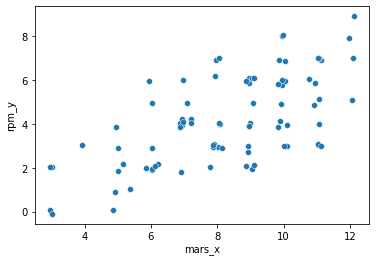

In [4]:
scores['mars_x'] = scores['mars'] + np.random.normal(0, 0.1, len(scores))
scores['rpm_y'] = scores['rpm'] + np.random.normal(0, 0.1, len(scores))
sns.scatterplot(x='mars_x', y='rpm_y', data=scores.query('mars > 1'))

<AxesSubplot:xlabel='mars', ylabel='count'>

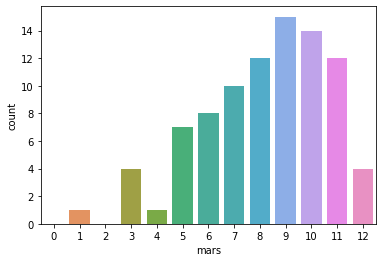

In [5]:
sns.countplot(x=scores['mars'], order=np.arange(13))

<AxesSubplot:xlabel='rpm', ylabel='count'>

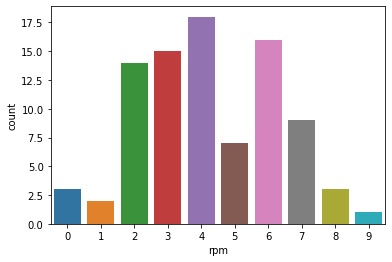

In [6]:
sns.countplot(x=scores['rpm'], order=np.arange(10))